# Import

In [1]:
import sys
sys.path.insert(1, '/home/bricej/MyPythonLibrary/StageM2_IVT/library/')
import domain
from domain import *
import compute_ivt
from compute_ivt import *
from climbas import *
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import calendar

# Domain

In [2]:
#load eastward (u) and northward (v) of IVT
uivt = xr.open_dataset('/bettik/PROJECTS/pr-regional-climate/bricej/era5/daily/uivt_daily_era5_2000-2025_NH_025x025.nc')
vivt = xr.open_dataset('/bettik/PROJECTS/pr-regional-climate/bricej/era5/daily/vivt_daily_era5_2000-2025_NH_025x025.nc')

In [ ]:
#focus on Middle Asia (MA)
uivt_MA = field_dom(uivt,'MA')
vivt_MA = field_dom(vivt,'MA')

# Compute IVT

In [4]:
#Découper le data par paquet de 10
uivt_MA = uivt_MA.chunk({'valid_time': 10})
vivt_MA = vivt_MA.chunk({'valid_time': 10})

#Compute IVT
ivt_MA = compute_ivt(uivt_MA, vivt_MA)

#Save as netcdf
#ivt_MA.to_netcdf('/bettik/PROJECTS/pr-regional-climate/bricej/era5/daily/ivt_daily_era5_2000-2025_MA_025x025.nc')

In [2]:
#Open file of IVT
ivt_MA = xr.open_dataset('/bettik/PROJECTS/pr-regional-climate/bricej/era5/daily/ivt_daily_era5_2000-2025_MA_025x025.nc')

In [3]:
ivt_mean = ivt_MA['ivt'].mean(dim='valid_time')

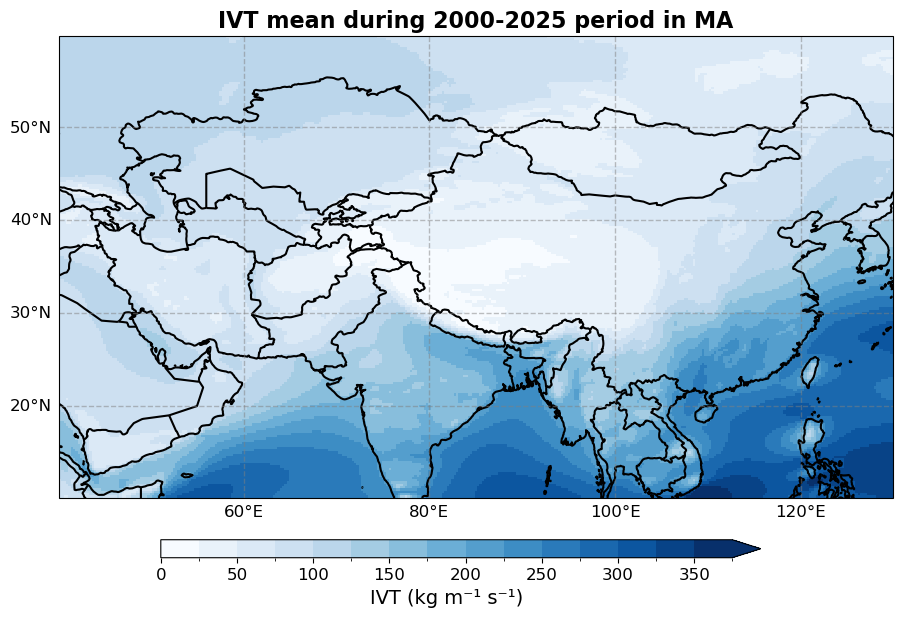

In [4]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12,6))

#IVT color definition
levels = np.arange(0, ivt_mean.max(), 25)
cmap = plt.get_cmap("Blues", len(levels)-1)
norm = mcolors.BoundaryNorm(levels, cmap.N)
pcm = ax.pcolormesh(
    ivt_mean['longitude'], ivt_mean['latitude'], ivt_mean,
    cmap=cmap, norm=norm,transform=ccrs.PlateCarree())

#Borders
ax.coastlines(linewidth=1.5)
ax.add_feature(cfeature.BORDERS, linewidth=1.5)

#Courbes de niveau
#elev = xr.open_dataset('/bettik/PROJECTS/pr-regional-climate/santolam/gmted/gmted_on_era5_grid.nc')['elevation']
#SH = ax.contour(elev.longitude,elev.latitude,elev,levels=[1000,2000,3000,4000,5000,6000,7000],
#                colors="k",linewidths=0.6,alpha=0.7,transform=ccrs.PlateCarree())
#ax.clabel(SH, inline=True, fontsize=9, fmt="%d")

#Grid of lat & lon
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 12}
gl.ylabel_style = {"size": 12}

#Colorbar & title
cbar_ax = fig.add_axes([0.25, 0.01, 0.5, 0.03])
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal', extend='max')
cbar.set_label("IVT (kg m⁻¹ s⁻¹)", fontsize=14)
cbar.ax.tick_params(labelsize=12)
ax.set_title("IVT mean during 2000-2025 period in MA", fontsize=16, weight='bold')

#HMA zone
#latS, latN, lonW, lonE, latlim, lonlim = coord_domain('HMA')
#rect = mpatches.Rectangle((lonW, latS), lonE - lonW, latN - latS,linewidth=2, edgecolor='red', facecolor='none',transform=ccrs.PlateCarree())
#ax.add_patch(rect)
#ax.text((lonW + lonE) / 2, latN + 3, "HMA",horizontalalignment='center',verticalalignment='center',fontsize=16,fontweight='bold',
#        color='black',transform=ccrs.PlateCarree(),zorder=7,bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', pad=3))

#Save
#plotsDir="/home/bricej/figures/climbas_IVT_era5/"
#plotname=f'ivt_mean_MA_2000-2025'
#plt.savefig(f"{plotsDir}{plotname}.png", bbox_inches="tight")
#print(f"Saved: {plotsDir}{plotname}.png")

plt.show()

# Monthly Climatology of IVT

In [5]:
#Group by month + mean
monthly_clim = ivt_MA.groupby('valid_time.month').mean('valid_time')['ivt']

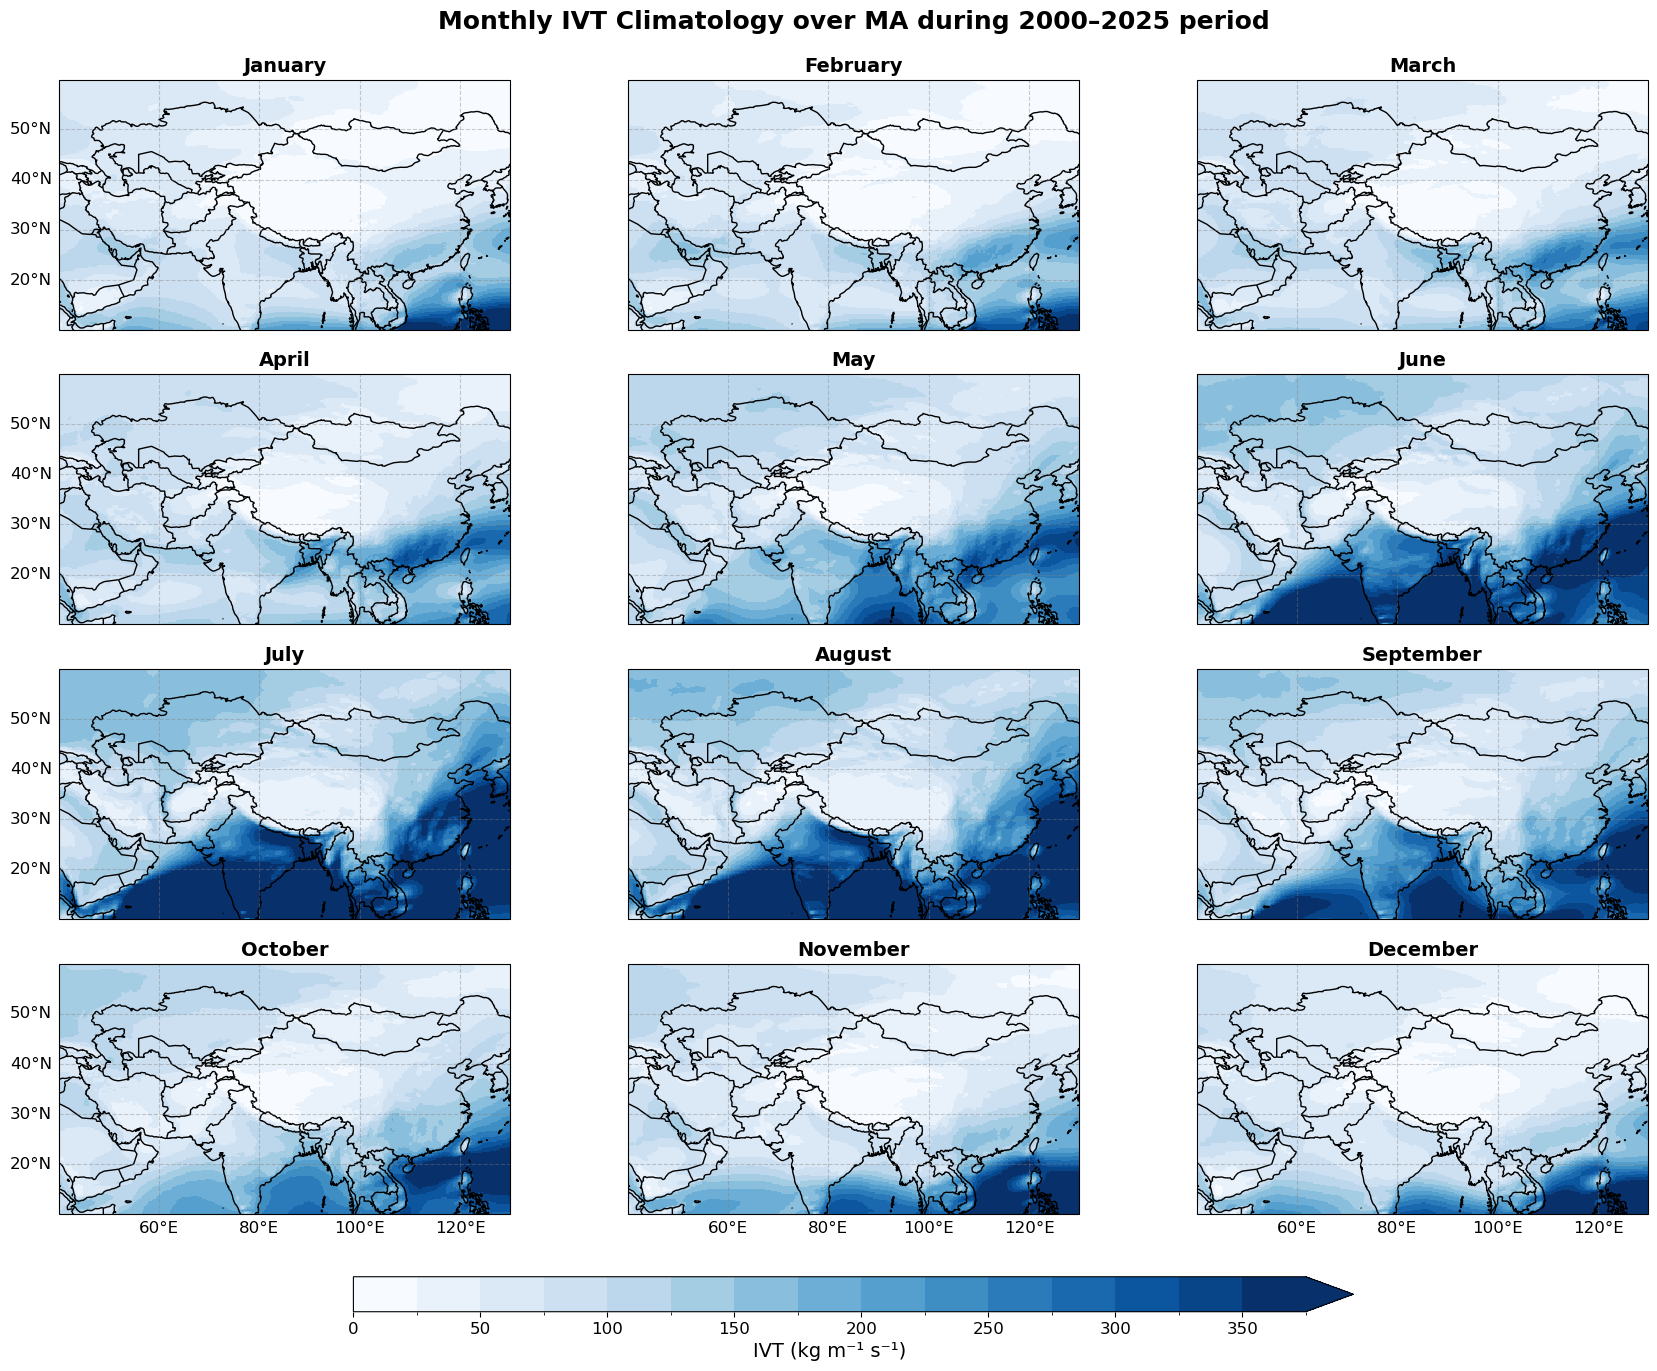

In [6]:
#vmax = float(monthly_clim.max())
levels = np.arange(0, 400, 25)
cmap = plt.get_cmap("Blues")
norm = mcolors.BoundaryNorm(levels, cmap.N)

fig, axes = plt.subplots(4, 3,figsize=(20, 14),subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, ax in enumerate(axes):
    data_month = monthly_clim.sel(month=i+1)
    im = ax.pcolormesh(data_month.longitude,data_month.latitude,data_month,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,shading="auto")

    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle="-")
    
    ax.set_title(calendar.month_name[i+1],fontsize=14,weight="bold")

    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=0.8,color="gray",alpha=0.4,linestyle="--")
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = (i % 3 == 0)
    gl.bottom_labels = (i >= 9)
    gl.xlabel_style = {"size": 12}
    gl.ylabel_style = {"size": 12}

cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.025])
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal", extend='max')
cbar.set_label("IVT (kg m⁻¹ s⁻¹)", fontsize=14)
cbar.ax.tick_params(labelsize=12)

fig.subplots_adjust(left=0.08,right=0.92,top=0.93,bottom=0.12,wspace=0.05,hspace=0.18)
plt.suptitle("Monthly IVT Climatology over MA during 2000–2025 period",fontsize=18,weight="bold")

#Save
#plotsDir="/home/bricej/figures/climbas_IVT_era5/"
#plotname=f'monthly_ivt_clim_MA_2000-2025'
#plt.savefig(f"{plotsDir}{plotname}.png", bbox_inches="tight")
#print(f"Saved: {plotsDir}{plotname}.png")

plt.show()

# Seasonal Climatology of IVT

In [7]:
seasons = ["DJFM", "AM", "JJAS", "ON"]
start_year = 2000
end_year = 2025
clim_dict = {}

#Rename time dimension for 'clim' function
ivt_MA = ivt_MA.rename({'valid_time': 'time'})

#Climatology for each season
for season in seasons:
    clim_season = clim(ivt_MA, season=season, imon=1, iyr=start_year, fmon=12, fyr=end_year)
    clim_dict[season] = clim_season

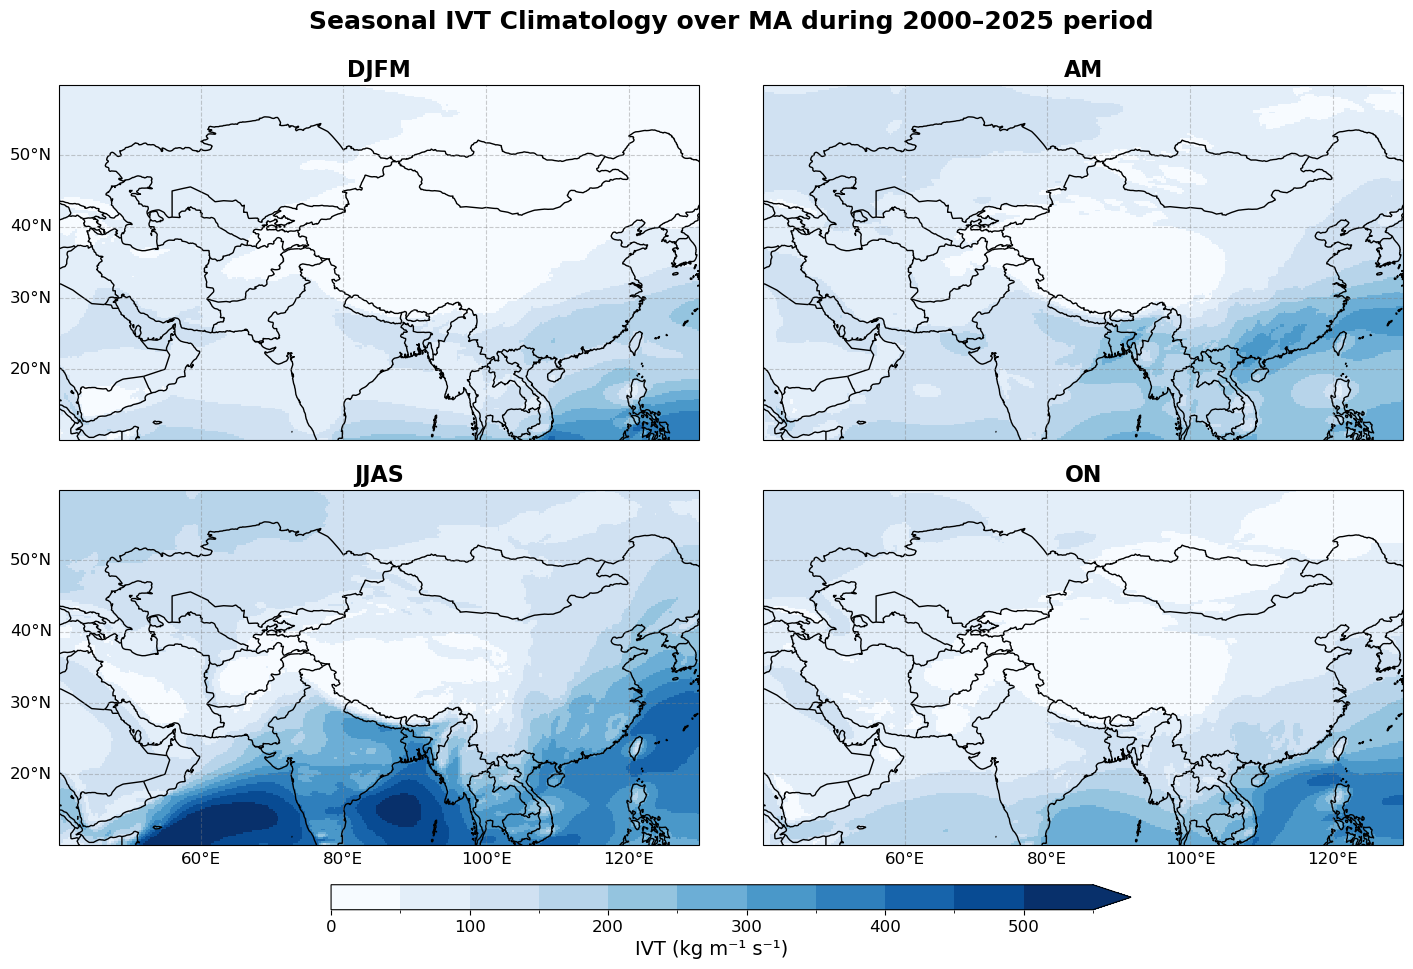

In [8]:
seasons = ["DJFM", "AM", "JJAS", "ON"]
vmin = 0
vmax = max(ds["ivt"].max().item() for ds in clim_dict.values())
elev = xr.open_dataset('/bettik/PROJECTS/pr-regional-climate/santolam/gmted/gmted_on_era5_grid.nc')['elevation']

levels = np.arange(vmin, vmax, 50)
cmap = plt.get_cmap("Blues")
norm = mcolors.BoundaryNorm(levels, cmap.N)

fig, axes = plt.subplots(2, 2, figsize=(16, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, ax in enumerate(axes):
    season = seasons[i]
    data_season = clim_dict[season]['ivt']

    im = ax.pcolormesh(data_season.longitude,data_season.latitude,data_season,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,shading="auto")

    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle="-")
    
    ax.set_title(season, fontsize=16, weight="bold")

    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=0.8,color="gray",alpha=0.4,linestyle="--")
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = (i % 2 == 0)
    gl.bottom_labels = (i >= 2) 
    gl.xlabel_style = {"size": 12}
    gl.ylabel_style = {"size": 12}

cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.025])
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal", extend='max')
cbar.set_label("IVT (kg m⁻¹ s⁻¹)", fontsize=14)
cbar.ax.tick_params(labelsize=12)

fig.subplots_adjust(left=0.08, right=0.92, top=0.93, bottom=0.12, wspace=0.1, hspace=0)
plt.suptitle("Seasonal IVT Climatology over MA during 2000–2025 period", fontsize=18, weight="bold")

#Save
#plotsDir="/home/bricej/figures/climbas_IVT_era5/"
#plotname=f'seasonal_ivt_clim_MA_2000-2025'
#plt.savefig(f"{plotsDir}{plotname}.png", bbox_inches="tight")
#print(f"Saved: {plotsDir}{plotname}.png")

plt.show()

# Annual Trend of IVT

In [9]:
ivt_annual,_ = seasonal_selection(ivt_MA['ivt'], 'JFMAMJJASOND', 2000, 2025)
par = trend_vect(ivt_annual.time,ivt_annual,dim='time')
trend = par[0];p = par[3]

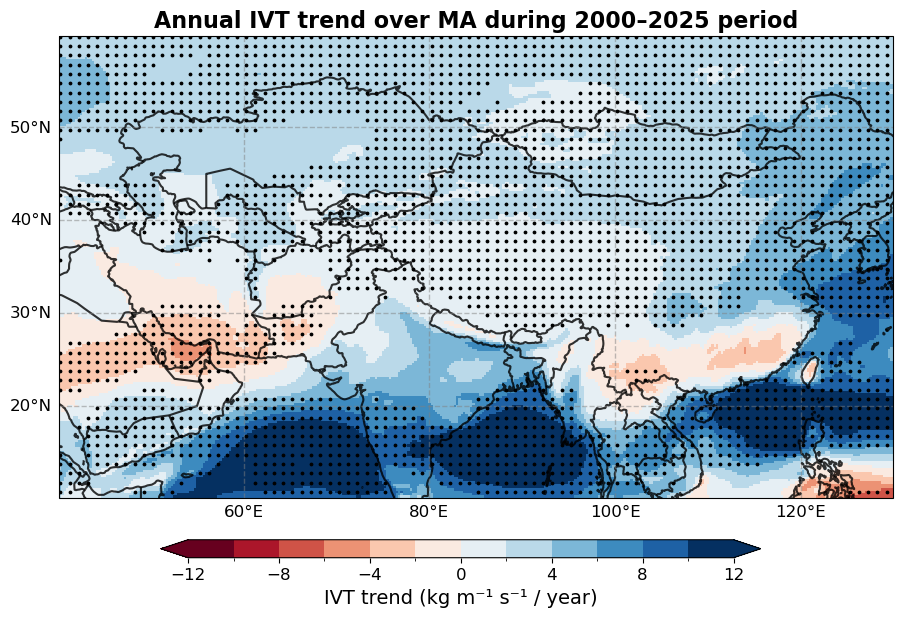

In [10]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12,6))

step = 2
vmax = 12
#vmax = np.ceil(np.abs(trend).max())
levels = np.linspace(-vmax, vmax, int(2*vmax/step)+1)
cmap = plt.get_cmap("RdBu", len(levels)-1)
norm = mcolors.BoundaryNorm(levels, ncolors=cmap.N)

pcm = ax.pcolormesh(trend['longitude'],trend['latitude'],trend,cmap=cmap,norm=norm,transform=ccrs.PlateCarree())

sig = p < 0.05   # significativity threshold
step = 4   # for stepping the points on the map that appears. 1 point out of 2 on every direction.
#ax.contourf(trend['longitude'],trend['latitude'],sig,levels=[0.5, 1],hatches=['///'],colors='none',transform=ccrs.PlateCarree())
lon_sig, lat_sig = trend['longitude'].values, trend['latitude'].values
lon_grid, lat_grid = np.meshgrid(lon_sig, lat_sig)
ax.scatter(lon_grid[::step, ::step][sig[::step, ::step]],lat_grid[::step, ::step][sig[::step, ::step]],
           color='black', s=3, marker='o', transform=ccrs.PlateCarree(), zorder=5)

ax.coastlines(linewidth=1.5, alpha = 0.8)
ax.add_feature(cfeature.BORDERS, linewidth=1.5, alpha = 0.8)

gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 12}
gl.ylabel_style = {"size": 12}

cbar_ax = fig.add_axes([0.25, 0.01, 0.5, 0.03])
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label("IVT trend (kg m⁻¹ s⁻¹ / year)", fontsize=14)
cbar.ax.tick_params(labelsize=12)

ax.set_title("Annual IVT trend over MA during 2000–2025 period", fontsize=16, weight='bold')

#Save
#plotsDir="/home/bricej/figures/climbas_IVT_era5/"
#plotname=f'ivt_trend_MA_2000-2025'
#plt.savefig(f"{plotsDir}{plotname}.png", bbox_inches="tight")
#print(f"Saved: {plotsDir}{plotname}.png")

plt.show()

# Monthly Trends of IVT

In [11]:
seasons = [1,2,3,4,5,6,7,8,9,10,11,12]
start_year = 2000
end_year = 2025
trend_dict = {}
p_dict = {}

#Rename time dimension for 'clim' function
#ivt_MA = ivt_MA.rename({'valid_time': 'time'})

#Climatology for each season
for season in seasons:
    ivt_season,_ = monthly_selection(ivt_MA['ivt'], season, start_year, end_year)
    par = trend_vect(ivt_season.time.dt.year,ivt_season,dim='time')
    trend_season = par[0];p_season = par[3]
    trend_dict[season] = trend_season
    p_dict[season] = p_season

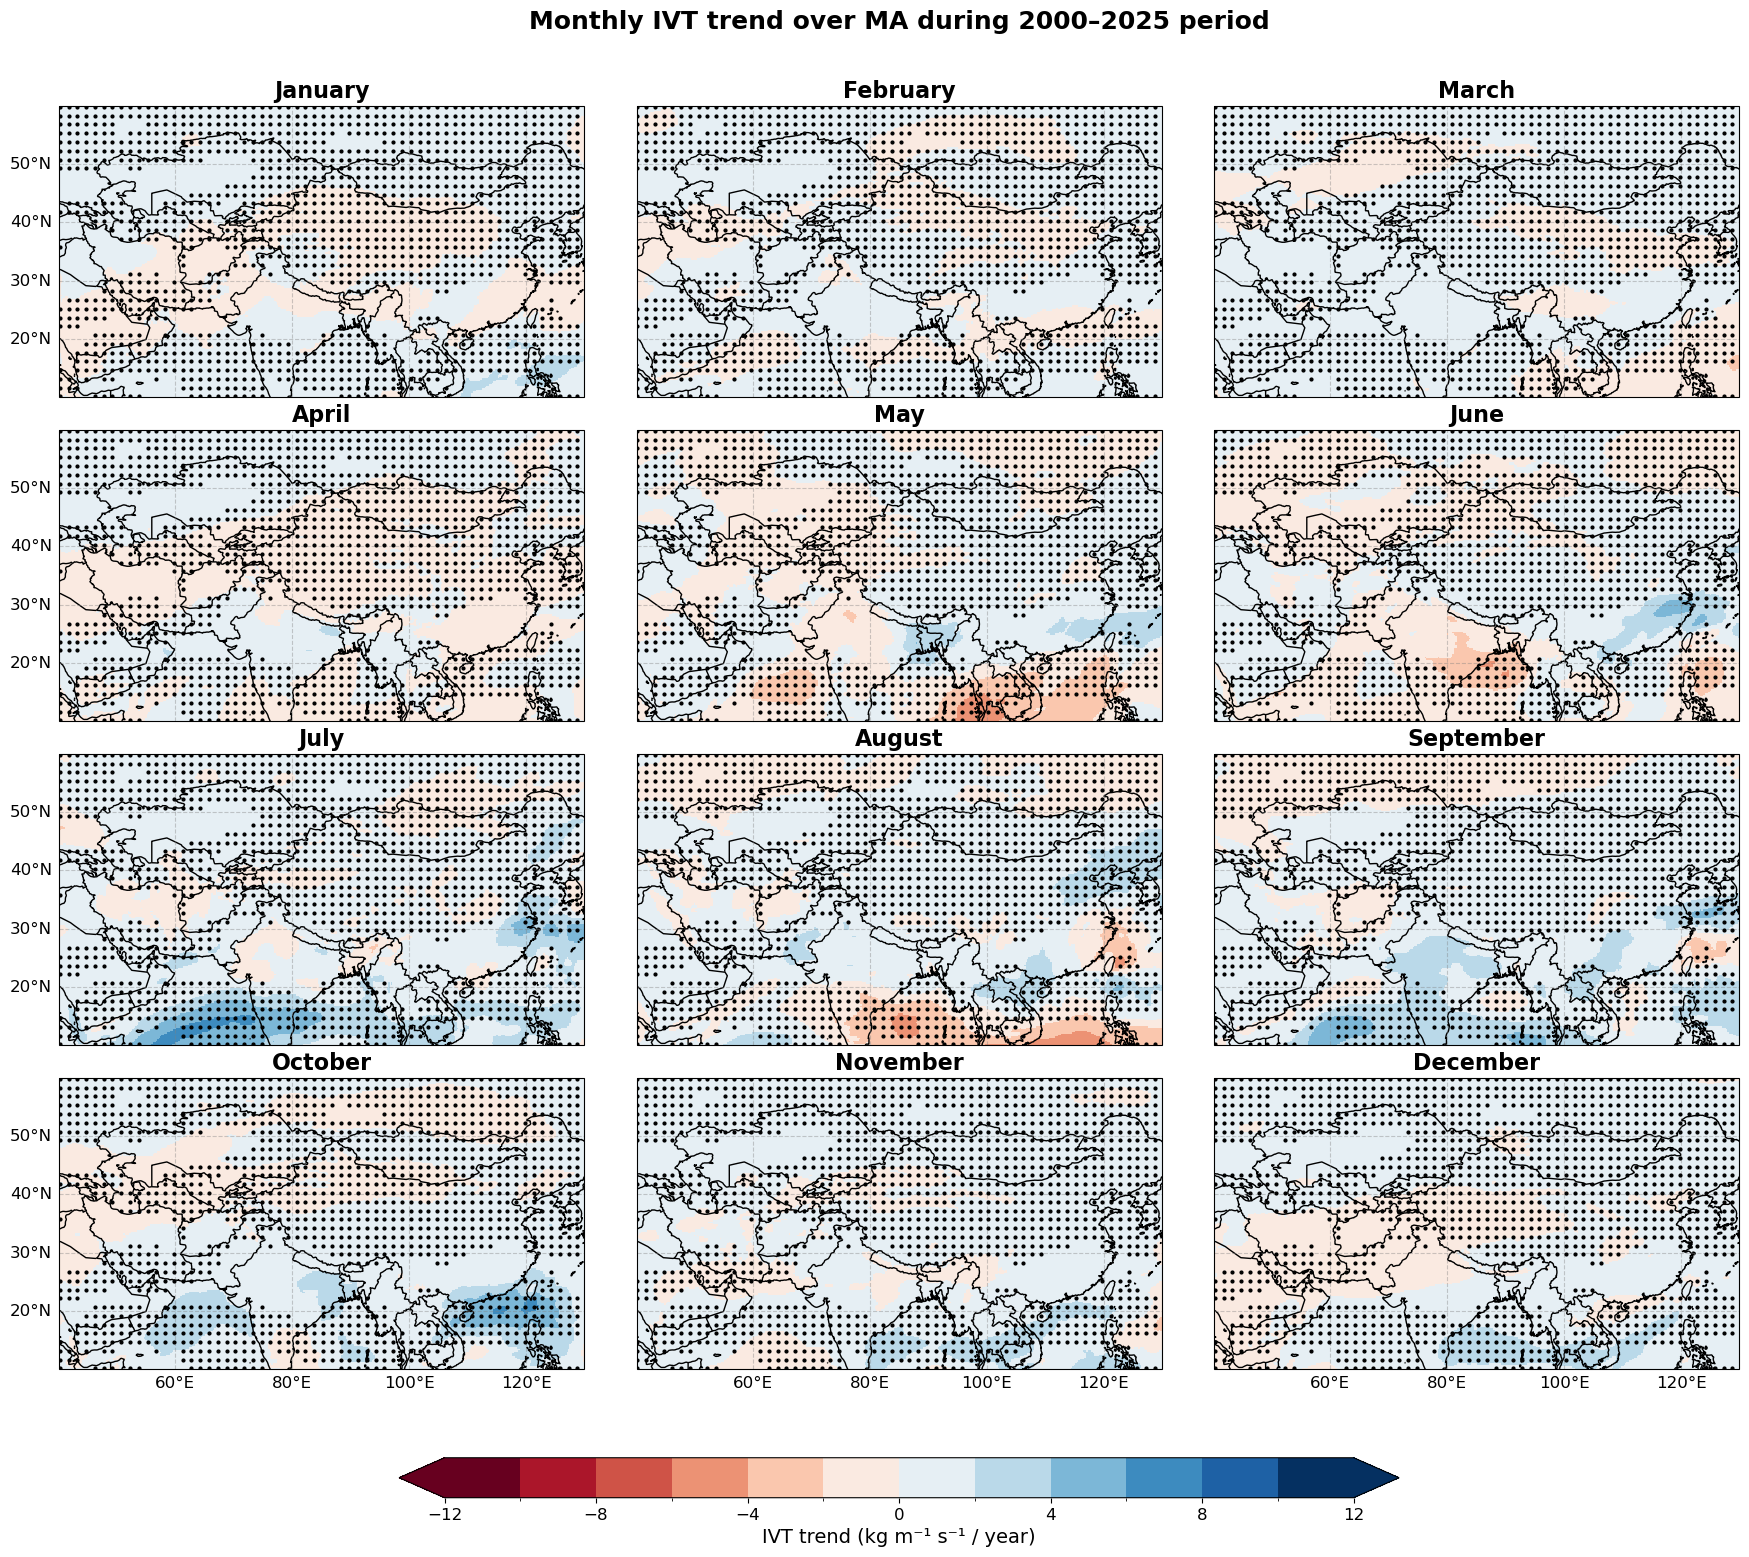

In [12]:
seasons_str = ["January", "February", "March", "April",
                "May", "June", "July", "August",
                "September", "October", "November", "December"]
elev = xr.open_dataset('/bettik/PROJECTS/pr-regional-climate/santolam/gmted/gmted_on_era5_grid.nc')['elevation']

step = 2
vmax = 12
#vmax = max(np.ceil(np.abs(ds).max()) for ds in trend_dict.values())
levels = np.linspace(-vmax, vmax, int(2*vmax/step)+1)
cmap = plt.get_cmap("RdBu", len(levels)-1)
norm = mcolors.BoundaryNorm(levels, ncolors=cmap.N)

fig, axes = plt.subplots(4, 3, figsize=(20, 16), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, ax in enumerate(axes):
    season = seasons[i]
    data_season = trend_dict[season]

    im = ax.pcolormesh(data_season['longitude'],data_season['latitude'],data_season,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,shading="auto")

    sig = p < 0.05   
    step = 6
    lon_sig, lat_sig = data_season['longitude'].values, data_season['latitude'].values
    lon_grid, lat_grid = np.meshgrid(lon_sig, lat_sig)
    ax.scatter(lon_grid[::step, ::step][sig[::step, ::step]],lat_grid[::step, ::step][sig[::step, ::step]],
           color='black', s=4, marker='o', transform=ccrs.PlateCarree(), zorder=5)
    
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle="-")
    
    ax.set_title(seasons_str[i], fontsize=16, weight="bold")

    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=0.8,color="gray",alpha=0.4,linestyle="--")
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = (i % 3 == 0)
    gl.bottom_labels = (i >= 9) 
    gl.xlabel_style = {"size": 12}
    gl.ylabel_style = {"size": 12}

cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.025])
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal", extend='both')
cbar.set_label("IVT trend (kg m⁻¹ s⁻¹ / year)", fontsize=14)
cbar.ax.tick_params(labelsize=12)

fig.subplots_adjust(left=0.08, right=0.92, top=0.93, bottom=0.12, wspace=0.1, hspace=0)
plt.suptitle("Monthly IVT trend over MA during 2000–2025 period", fontsize=18, weight="bold")

#Save
#plotsDir="/home/bricej/figures/climbas_IVT_era5/"
#plotname=f'monthly_ivt_trend_MA_2000-2025'
#plt.savefig(f"{plotsDir}{plotname}.png", bbox_inches="tight")
#print(f"Saved: {plotsDir}{plotname}.png")

plt.show()

# Seasonal Trends of IVT

In [13]:
seasons = ["DJFM", "AM", "JJAS", "ON"]
start_year = 2000
end_year = 2025
trend_dict = {}
p_dict = {}

#Rename time dimension for 'clim' function
#ivt_MA = ivt_MA.rename({'valid_time': 'time'})

#Climatology for each season
for season in seasons:
    ivt_season,_ = seasonal_selection(ivt_MA['ivt'], season, start_year, end_year)
    par = trend_vect(ivt_season.time,ivt_season,dim='time')
    trend_season = par[0];p_season = par[3]
    trend_dict[season] = trend_season
    p_dict[season] = p_season

(D- 2000  JF- 2001  to D- 2025 JF- 2026


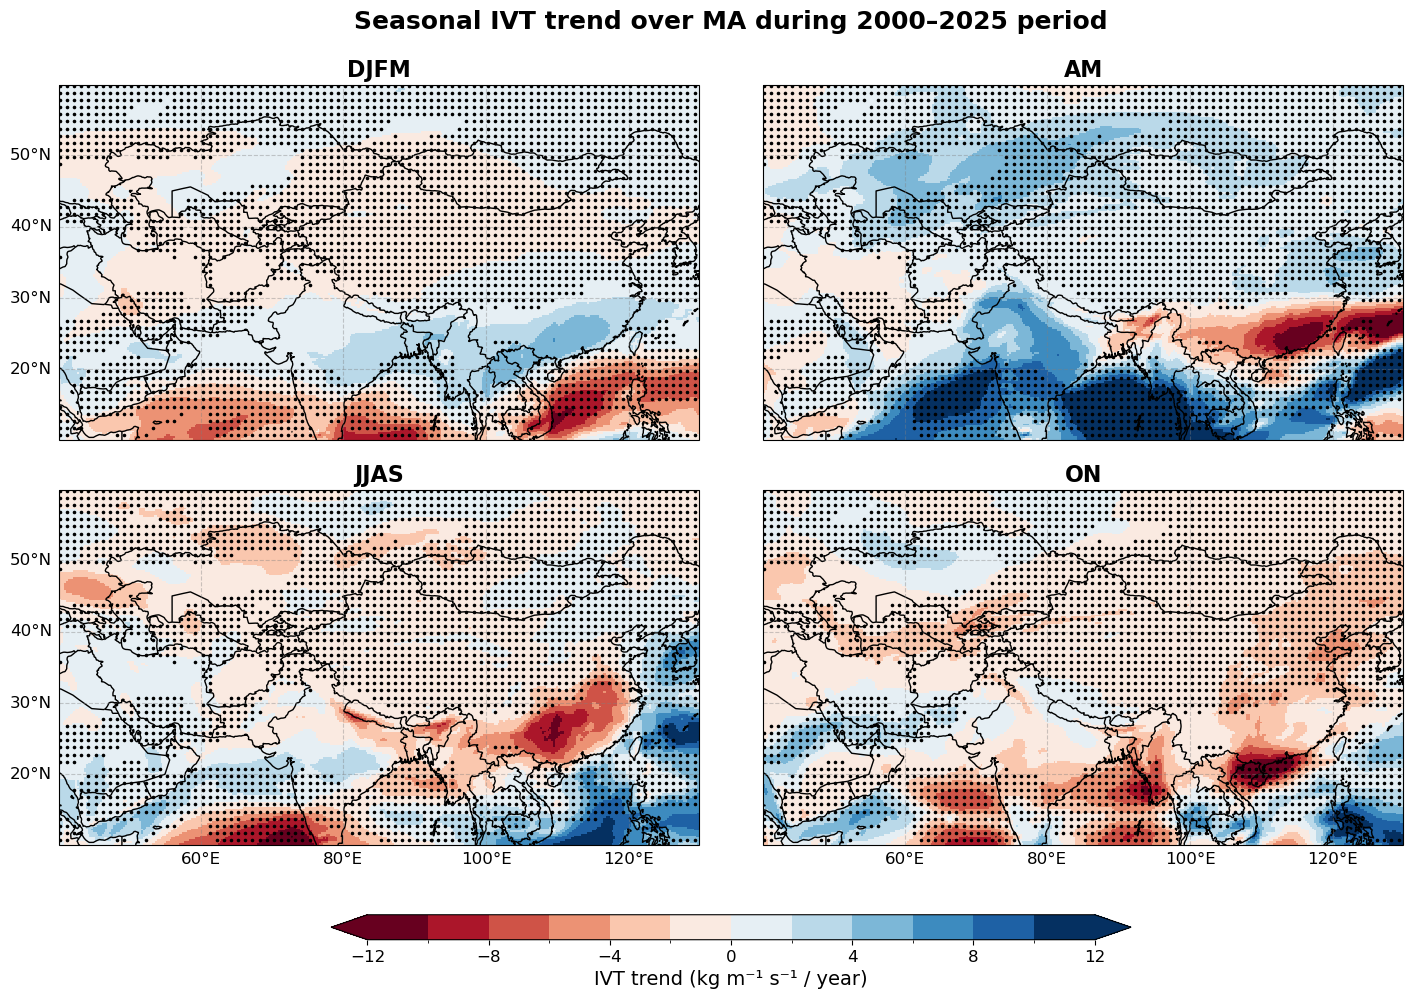

In [14]:
step = 2
vmax = 12
#vmax = max(np.ceil(np.abs(ds).max()) for ds in trend_dict.values())
levels = np.arange(-vmax, vmax + step, step)
cmap = plt.get_cmap("RdBu", len(levels)-1)
norm = mcolors.BoundaryNorm(levels, ncolors=cmap.N)

fig, axes = plt.subplots(2, 2, figsize=(16, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, ax in enumerate(axes):
    season = seasons[i]
    data_season = trend_dict[season]

    im = ax.pcolormesh(data_season['longitude'],data_season['latitude'],data_season,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,shading="auto")

    sig = p < 0.05   
    step = 4
    lon_sig, lat_sig = data_season['longitude'].values, data_season['latitude'].values
    lon_grid, lat_grid = np.meshgrid(lon_sig, lat_sig)
    ax.scatter(lon_grid[::step, ::step][sig[::step, ::step]],lat_grid[::step, ::step][sig[::step, ::step]],
           color='black', s=2.5, marker='o', transform=ccrs.PlateCarree(), zorder=5)
    
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle="-")
    
    ax.set_title(season, fontsize=16, weight="bold")

    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=0.8,color="gray",alpha=0.4,linestyle="--")
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = (i % 2 == 0)
    gl.bottom_labels = (i >= 2) 
    gl.xlabel_style = {"size": 12}
    gl.ylabel_style = {"size": 12}

cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.025])
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal", extend='both')
cbar.set_label("IVT trend (kg m⁻¹ s⁻¹ / year)", fontsize=14)
cbar.ax.tick_params(labelsize=12)

fig.subplots_adjust(left=0.08, right=0.92, top=0.93, bottom=0.12, wspace=0.1, hspace=0)
plt.suptitle("Seasonal IVT trend over MA during 2000–2025 period", fontsize=18, weight="bold")

#Save
#plotsDir="/home/bricej/figures/climbas_IVT_era5/"
#plotname=f'monthly_ivt_trend_MA_2000-2025'
#plt.savefig(f"{plotsDir}{plotname}.png", bbox_inches="tight")
#print(f"Saved: {plotsDir}{plotname}.png")

plt.show()